## M√°ster en Data Science - Series Temporales

# ETS Model
Autor: Ram√≥n Morillo Barrera

## Dataset: Madrid.csv

Los modelos ETS (Error, Tendencia, Estacionalidad) son una familia de modelos de suavizamiento exponencial que descomponen una serie temporal en tres componentes principales: el error (ùê∏), la tendencia (ùëá) y la estacionalidad (ùëÜ). Dependiendo de c√≥mo interact√∫en estos componentes (de manera aditiva o multiplicativa), los modelos ETS pueden capturar patrones de datos con diferentes caracter√≠sticas de crecimiento y estacionalidad. Estos modelos son particularmente √∫tiles para series temporales con patrones regulares, ya que son flexibles y se adaptan bien tanto a tendencias suaves como a fluctuaciones estacionales recurrentes.

El an√°lisis de la predicci√≥n de pasajeros de autob√∫s y metro en Madrid mediante modelos ETS permitir√° evaluar c√≥mo se desempe√±an en comparaci√≥n con los modelos ARIMA y SARIMA. Dado que las series presentan tanto estacionalidad como posibles tendencias a lo largo del tiempo, los modelos ETS son una opci√≥n adecuada para capturar dichas din√°micas de forma expl√≠cita y directa. En este contexto, examinaremos el ajuste y la precisi√≥n predictiva de los modelos ETS utilizando m√©tricas clave como MSE, RMSE y MAPE, para determinar si son capaces de ofrecer una ventaja adicional en la predicci√≥n de estas series temporales.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, MeanSquaredError
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

### Importaci√≥n de datos

In [17]:
df_autobus_month = pd.read_csv('../data/processed/Madrid_autobus_month.csv', index_col='Periodo')
df_metro_month = pd.read_csv('../data/processed/Madrid_metro_month.csv', index_col='Periodo')
df_combined_month = pd.read_csv('../data/processed/Madrid_combined_month.csv', index_col='Periodo')

df_autobus_trim = pd.read_csv('../data/processed/Madrid_autobus_trim.csv', index_col='Periodo')
df_metro_trim = pd.read_csv('../data/processed/Madrid_metro_trim.csv', index_col='Periodo')
df_combined_trim = pd.read_csv('../data/processed/Madrid_combined_trim.csv', index_col='Periodo')

In [18]:
df_autobus_month = df_autobus_month[ 'Total']
df_autobus_trim = df_autobus_trim['Total']
df_combined_month = df_combined_month[ 'Total']
df_combined_trim = df_combined_trim['Total']
df_metro_month = df_metro_month['Total']
df_metro_trim = df_metro_trim['Total']

### Convertimos datos en formato SKtime

In [19]:
df_autobus_month.index = pd.to_datetime(df_autobus_month.index)
df_autobus_trim.index = pd.to_datetime(df_autobus_trim.index)
df_combined_month.index = pd.to_datetime(df_combined_month.index)
df_combined_trim.index = pd.to_datetime(df_combined_trim.index)
df_metro_month.index = pd.to_datetime(df_metro_month.index)
df_metro_trim.index = pd.to_datetime(df_metro_trim.index)

df_autobus_month = df_autobus_month.resample("M").last()
df_autobus_trim = df_autobus_trim.resample("QE").last()
df_combined_month = df_combined_month.resample("M").last()
df_combined_trim = df_combined_trim.resample("QE").last()
df_metro_month = df_metro_month.resample("M").last()
df_metro_trim = df_metro_trim.resample("QE").last()

***

## Predicci√≥n mediante ETS

Entrenar un modelo AUTOETS en lugar de configurarlo manualmente ofrece varias ventajas significativas. AUTOETS utiliza m√©todos automatizados para seleccionar de manera √≥ptima la combinaci√≥n de componentes (error, tendencia y estacionalidad) que mejor se ajusta a la serie temporal, eliminando la necesidad de probar m√∫ltiples configuraciones manualmente. Esto no solo ahorra tiempo y esfuerzo, sino que tambi√©n reduce el riesgo de sesgos o errores en la selecci√≥n del modelo. Adem√°s, AUTOETS utiliza criterios estad√≠sticos como el AIC o BIC para garantizar que el modelo final balancee adecuadamente el ajuste y la complejidad, lo que mejora la precisi√≥n predictiva y evita el sobreajuste.

Realizar√© la predicci√≥n por separado para las series mensuales y trimestrales ya que tengo que establecer los valores del horizonte temporal y del componente estacional para cada tipo de serie.

<Figure size 1400x700 with 0 Axes>

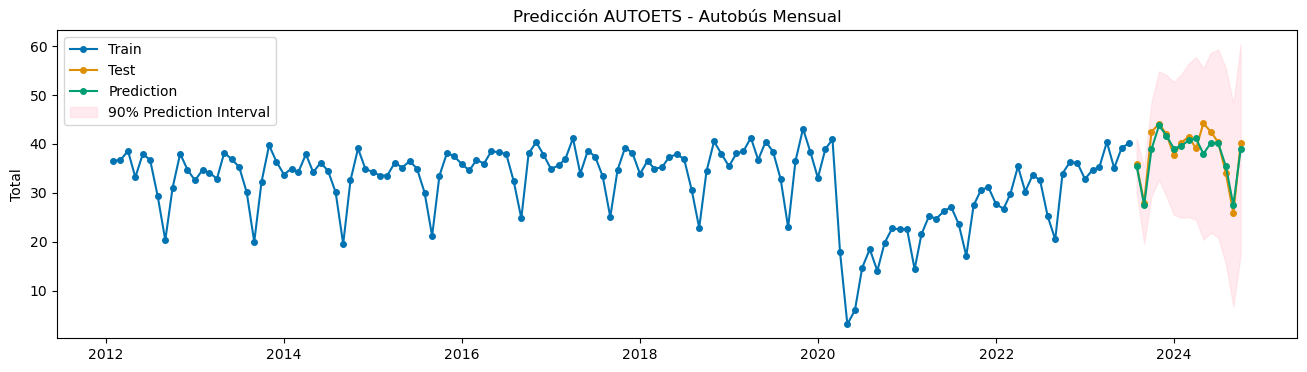

<Figure size 1400x700 with 0 Axes>

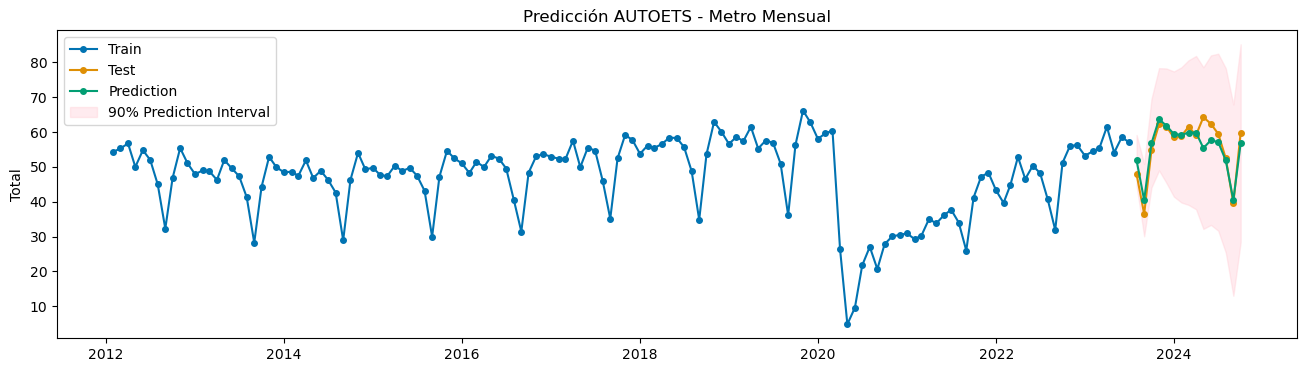

<Figure size 1400x700 with 0 Axes>

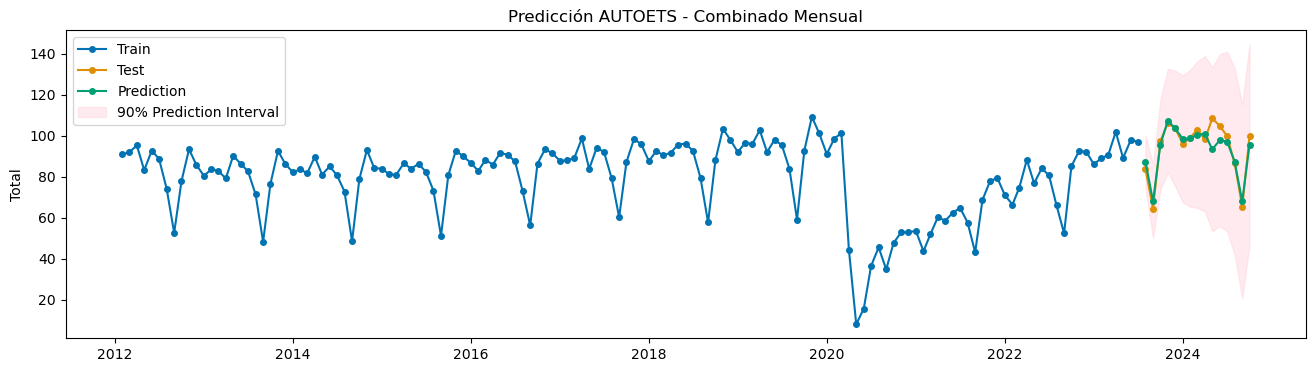

In [20]:
# Definir una funci√≥n para realizar predicciones y graficar los resultados
def forecast_and_plot(series, title, sp, test_size):
    # Dividir los datos en entrenamiento y prueba
    y_train, y_test = temporal_train_test_split(series, test_size=test_size)
    
    # Definir el horizonte de predicci√≥n
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    
    # Crear y ajustar el modelo AutoETS
    forecaster = AutoETS(auto=True, sp=sp, n_jobs=-1)
    forecaster.fit(y_train)
    
    # Realizar predicciones
    y_pred = forecaster.predict(fh)
    
    # Obtener el intervalo de confianza al 90%
    y_pred_int = forecaster.predict_interval(fh, coverage=0.90)
    
    # Asegurarse de que las columnas 'lower' y 'upper' existan
    if 'lower' not in y_pred_int.columns or 'upper' not in y_pred_int.columns:
        y_pred_int.columns = ['lower', 'upper']
    
    # Graficar los resultados
    plt.figure(figsize=(14, 7))
    plot_series(y_train, y_test, y_pred, labels=["Train", "Test", "Prediction"])
    plt.fill_between(y_pred_int.index, y_pred_int["lower"], y_pred_int["upper"], color='pink', alpha=0.3, label="90% Prediction Interval")
    plt.title(title)
    plt.legend()
    plt.show()

# Realizar predicciones y graficar para cada dataframe mensual con sp=12 y test_size=15
forecast_and_plot(df_autobus_month, "Predicci√≥n AUTOETS - Autob√∫s Mensual", sp=12, test_size=15)
forecast_and_plot(df_metro_month, "Predicci√≥n AUTOETS - Metro Mensual", sp=12, test_size=15)
forecast_and_plot(df_combined_month, "Predicci√≥n AUTOETS - Combinado Mensual", sp=12, test_size=15)

Visualmente las predicciones mensuales se ajustan muy bien a la muestra de test, algo mejor que los modelos ARIMA y SARIMA, lo comprobaremos con las m√©tricas de evaluaci√≥n.

In [21]:
# Definir una funci√≥n para realizar predicciones y calcular m√©tricas
def forecast_and_calculate_metrics(series, sp, test_size):
    # Dividir los datos en entrenamiento y prueba
    y_train, y_test = temporal_train_test_split(series, test_size=test_size)
    
    # Definir el horizonte de predicci√≥n
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    
    # Crear y ajustar el modelo AutoETS
    forecaster = AutoETS(auto=True, sp=sp, n_jobs=-1)
    forecaster.fit(y_train)
    
    # Realizar predicciones
    y_pred = forecaster.predict(fh)
    
    # Calcular m√©tricas
    mse = MeanSquaredError()(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    return mse, rmse, mape

# Calcular m√©tricas para cada dataframe mensual
mse_autobus_month, rmse_autobus_month, mape_autobus_month = forecast_and_calculate_metrics(df_autobus_month, sp=12, test_size=15)
mse_metro_month, rmse_metro_month, mape_metro_month = forecast_and_calculate_metrics(df_metro_month, sp=12, test_size=15) 
mse_combined_month, rmse_combined_month, mape_combined_month = forecast_and_calculate_metrics(df_combined_month, sp=12, test_size=15)

# Mostrar resultados
print("M√©tricas para Autob√∫s Mensual:")
print(f"MSE: {mse_autobus_month}, RMSE: {rmse_autobus_month}, MAPE: {mape_autobus_month}")

print("\nM√©tricas para Metro Mensual:")
print(f"MSE: {mse_metro_month}, RMSE: {rmse_metro_month}, MAPE: {mape_metro_month}")

print("\nM√©tricas para Combinado Mensual:")
print(f"MSE: {mse_combined_month}, RMSE: {rmse_combined_month}, MAPE: {mape_combined_month}")


M√©tricas para Autob√∫s Mensual:
MSE: 4.718598852179303, RMSE: 2.1722336090253513, MAPE: 0.038964134894091666

M√©tricas para Metro Mensual:
MSE: 10.574237900366414, RMSE: 3.251805329408022, MAPE: 0.04355536794726542

M√©tricas para Combinado Mensual:
MSE: 23.827076473422597, RMSE: 4.881298646202934, MAPE: 0.03511846408082429


Las tres series presentan unas mejores m√©tricas de predicci√≥n, el MAPE apenas sube al 4.35% en la serie temporal mensual del metro. Por ahora, son los modelos que mejor se ajustan a los datos y captan la tendencia y la estacionalidad de los mismos.

<Figure size 1400x700 with 0 Axes>

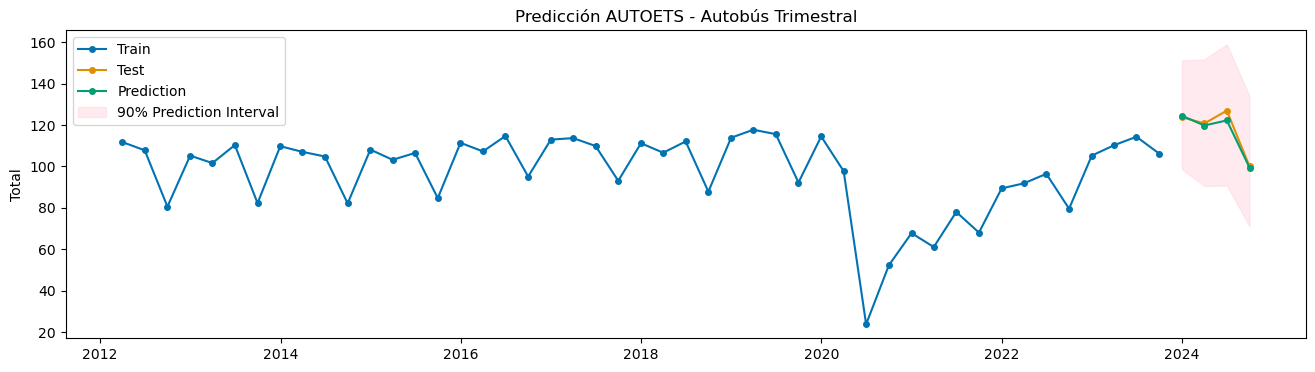

<Figure size 1400x700 with 0 Axes>

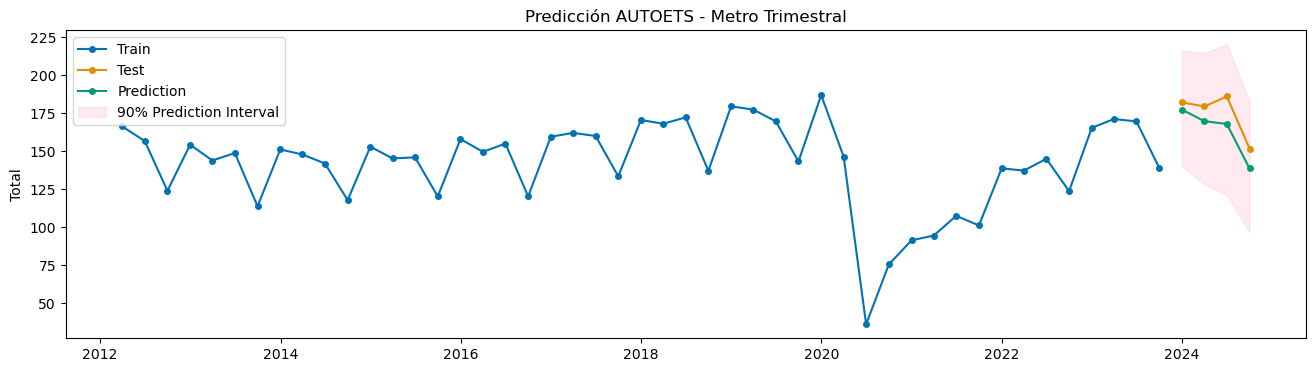

<Figure size 1400x700 with 0 Axes>

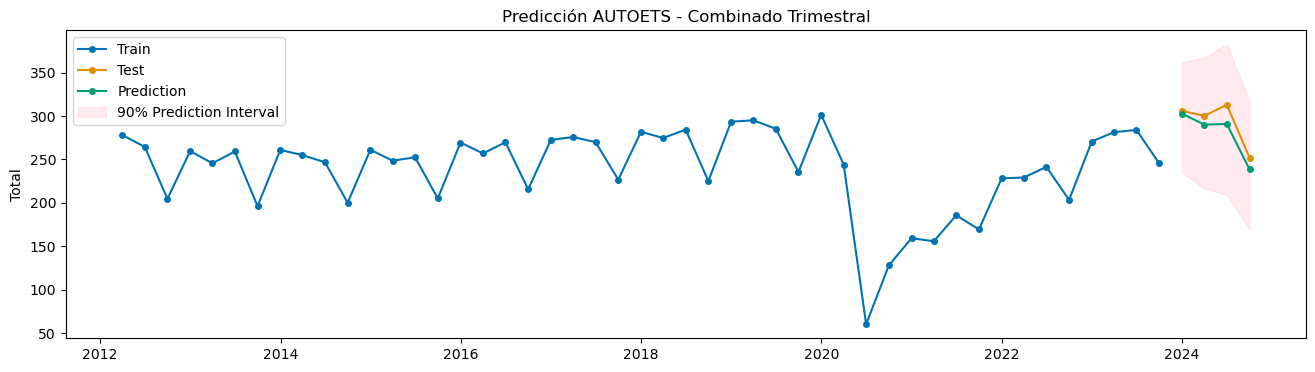

In [22]:
# Realizar predicciones y graficar para cada dataframe trimestral con sp=4 y test_size=8
forecast_and_plot(df_autobus_trim, "Predicci√≥n AUTOETS - Autob√∫s Trimestral", sp=4, test_size=4)
forecast_and_plot(df_metro_trim, "Predicci√≥n AUTOETS - Metro Trimestral", sp=4, test_size=4)
forecast_and_plot(df_combined_trim, "Predicci√≥n AUTOETS - Combinado Trimestral", sp=4, test_size=4)

De manera trimestral, la predicci√≥n de los pasajeros de autob√∫s parece muy buena, mientras que la del metro y combinado no tanto, aunque no malas. Evaluaremos las m√©tricas.

In [25]:
# Calcular m√©tricas para cada dataframe trimestral
mse_autobus_trim, rmse_autobus_trim, mape_autobus_trim = forecast_and_calculate_metrics(df_autobus_trim, sp=4, test_size=4)
mse_metro_trim, rmse_metro_trim, mape_metro_trim = forecast_and_calculate_metrics(df_metro_trim, sp=4, test_size=4)
mse_combined_trim, rmse_combined_trim, mape_combined_trim = forecast_and_calculate_metrics(df_combined_trim, sp=4, test_size=4)
# Mostrar resultados
print("M√©tricas para Autob√∫s Trimestral:")
print(f"MSE: {mse_autobus_trim}, RMSE: {rmse_autobus_trim}, MAPE: {mape_autobus_trim}")

print("\nM√©tricas para Metro Trimestral:")
print(f"MSE: {mse_metro_trim}, RMSE: {rmse_metro_trim}, MAPE: {mape_metro_trim}")

print("\nM√©tricas para Combinado Trimestral:")
print(f"MSE: {mse_combined_trim}, RMSE: {rmse_combined_trim}, MAPE: {mape_combined_trim}")


M√©tricas para Autob√∫s Trimestral:
MSE: 6.041031249196908, RMSE: 2.4578509412079708, MAPE: 0.014211584720710659

M√©tricas para Metro Trimestral:
MSE: 153.83868163959468, RMSE: 12.40317224098717, MAPE: 0.06590390395338475

M√©tricas para Combinado Trimestral:
MSE: 194.2642574724126, RMSE: 13.937871339354967, MAPE: 0.041847361695736864


La predicci√≥n trimestral de pasajeros de autob√∫s es la mejor hasta la que hemos realizado, con un MAPE del 1.42% y un MSE de 6.04 puntos. Por ahora, los modelos ETS son los candidatos a realizar las predicciones finales de la serie temporal. En los siguientes notebooks veremos predicciones con modelos Bats, Theta, CES y modelos de machine learning como Prophet o Causal Impact.

*** 
## Conclusi√≥n ETS

Las m√©tricas obtenidas para los modelos ETS muestran claras ventajas en comparaci√≥n con los modelos ARIMA previamente utilizados. En particular, los modelos mensuales, especialmente el de autob√∫s, presentan un rendimiento notable con valores bajos de MSE, RMSE y MAPE, lo que indica predicciones m√°s precisas y con un menor margen de error. Este resultado subraya la efectividad de los modelos ETS para captar patrones de corto plazo, como tendencias y estacionalidades, de manera m√°s eficiente que ARIMA en este caso. Aunque los modelos trimestrales tienen un rendimiento algo m√°s variable, en general, los modelos ETS siguen ofreciendo mejores resultados que ARIMA, sobre todo en periodos m√°s cortos. Esto resalta las ventajas de ETS frente a ARIMA, ya que, al ser m√°s simples y adaptarse mejor a cambios en los datos, permiten obtener predicciones m√°s exactas y confiables, especialmente cuando la serie temporal tiene una fuerte estacionalidad o tendencia.